![Astrofisica Computacional](../../../logo.png)

---
## 04. Multidimensional Linear Regression Algorithm.


Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### About this notebook

In this worksheet, we implement a multidimensional linear regression algorithm using an optimization procedure.

---

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import ascii

import pandas as pd
%matplotlib inline

# No warnings
import warnings
warnings.filterwarnings('ignore')

### Green and Ho data

Consider the dataset reported by Greene and Ho (2006), containing the features of 88 galaxies. 

Greene, J. E. and Ho, L. C. *The MBH − σ∗ Relation in Local Active Galaxies*. ApJ 641 L21 (2006)
https://ui.adsabs.harvard.edu/abs/2006ApJ...641L..21G/abstract

The dataset is available online in various formats at

http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJ/641/L21.


In [16]:
data = ascii.read('data/table1.dat', readme='data/ReadMe')
df = data.to_pandas()
df

,Name,z,sigma*,e_sigma*,n_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM
0,SDSS J000805.62+145023.4,0.045400,140.0,27.0,NaN,7610,380,41.13,0.04,7.70,NaN,0.10
1,SDSS J004236.86-104921.8,0.041900,78.4,10.0,NaN,1960,97,41.58,0.14,6.70,NaN,0.10
2,SDSS J011703.58+000027.3,0.045600,98.8,16.0,NaN,2270,110,41.45,0.08,6.80,NaN,0.10
3,SDSS J020459.25-080816.0,0.077200,121.0,9.4,a,3720,180,41.13,0.05,7.00,NaN,0.10
4,SDSS J020615.99-001729.1,0.042600,216.0,30.0,NaN,3860,190,41.91,0.07,7.50,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...
83,NGC 4151,0.003320,96.8,2.9,NaN,<NA>,<NA>,NaN,NaN,6.91,0.17,0.29
84,NGC 5548,0.017200,198.0,11.0,NaN,<NA>,<NA>,NaN,NaN,7.81,0.02,0.02
85,NGC 7469,0.016300,133.0,4.8,NaN,<NA>,<NA>,NaN,NaN,6.49,0.16,0.27
86,POX 52,0.021800,36.0,5.0,NaN,<NA>,<NA>,NaN,NaN,5.20,NaN,0.30


We will make a linear fit between the variables $\log M$ and $\log \left( \frac{\sigma_*}{\sigma_0} \right)$ and between the varibles $\log M$ and $\log  \text{FWHM} $, where $\sigma_0 = 200.$ is a reference value given by the authors. Hence, we add the corresponding columns to the dataframe.

In [17]:
sigma0 = 200.
df['logsigma*'] = np.log10(df['sigma*']/sigma0)
df['logFWHM'] = np.log10(df['FWHM'])
df.describe()

,z,sigma*,e_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM,logsigma*,logFWHM
count,88.000000,88.000000,88.000000,71.0,71.0,71.000000,71.000000,88.00000,15.000000,88.000000,88.000000,71.0
mean,0.048665,117.142045,11.805682,3206.056338,210.760563,41.504225,0.078028,6.86625,0.140667,0.189886,-0.272206,3.440999
std,0.032562,48.285108,5.308383,1759.679743,191.219953,0.663268,0.041700,0.72825,0.074303,0.172470,0.195820,0.246118
min,0.000947,30.000000,2.900000,810.0,41.0,40.100000,0.030000,4.90000,0.020000,0.020000,-0.823909,2.908485
25%,0.027750,87.025000,7.750000,1905.0,110.0,41.155000,0.050000,6.30000,0.100000,0.100000,-0.361386,3.279893
50%,0.042250,113.500000,12.000000,2970.0,160.0,41.510000,0.070000,7.00000,0.120000,0.100000,-0.246038,3.472756
75%,0.062200,139.250000,15.000000,3870.0,210.0,41.860000,0.090000,7.40750,0.170000,0.200000,-0.157237,3.58771
max,0.184000,268.000000,30.000000,8240.0,1190.0,43.610000,0.200000,8.52000,0.310000,1.060000,0.127105,3.915927


In [18]:
newdf = df[['logM','logsigma*','logFWHM']]
newdf = newdf.apply (pd.to_numeric, errors='coerce')
newdf = newdf.dropna()
newdf.describe()

,logM,logsigma*,logFWHM
count,71.000000,71.000000,71.0
mean,6.819718,-0.286024,3.440999
std,0.660653,0.176979,0.246118
min,5.100000,-0.744727,2.908485
25%,6.300000,-0.380551,3.279893
50%,6.900000,-0.255707,3.472756
75%,7.300000,-0.161151,3.58771
max,8.200000,0.077368,3.915927


In [19]:
Xdf = np.asarray(newdf[['logsigma*','logFWHM']])
ydf = np.asarray(newdf[['logM']])

print('Xdf shape : ', Xdf.shape)
print('ydf shape : ', ydf.shape)

Xdf shape :  (71, 2)
ydf shape :  (71, 1)


### Linear Fit

We will separate the dataframes into two sets, a training set and a testing set. We will use the function `train_test_split` function from the `sklearn.model_selection` package. We will use a size of 10% for the test set. More information on this function at

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=60, test_size=0.15)

In [7]:
X_train.shape , y_train.shape

((60, 2), (60, 1))

In [8]:
X_test.shape , y_test.shape

((11, 2), (11, 1))

### Implementing the Linear Regression Algorithm


The class function also includes the method `.score()` which returns the coefficient of determination $R^2$ for the model. This is defined as

$R^2 = 1 - \frac{\Sigma (a_1 + a_2 x_i - y_i)^2}{\Sigma (y_i - \bar{y})^2} = 1 - \frac{\Sigma (y(x_i) - y_i)^2}{\Sigma (y_i - \bar{y})^2}$

where $\bar{y} = \frac{1}{N} \Sigma y_i$ is the mean value of the y-data.The best possible score is $R^2 = 1.0$ and it can take negative values, because the model can be arbitrarily worse. A constant model that always predicts the expected value of each y, disregarding the input features, would get a score of $R^2 = 0.0$.

In [20]:
class LinearRegression():
    '''
    Linear regression class
    '''
    def __init__(self):
        pass 

    def predict(self, X):
        '''
        Function to fit
        '''
        return self.b + np.dot(X,self.W)
    
    def cost(self, X, y):
        '''
        Cost function
        '''
        #delta = np.zeros_like(y)
        delta = self.predict(X) - y
        return np.sum(delta**2)
    
    def grad_cost(self, X, y):
        '''
        Gradient of the cost function
        '''
        delta = self.predict(X) - y
        grad_dW = 2*np.sum(delta*X)
        grad_db = 2*np.sum(delta)
        return grad_dW, grad_db
    
    def fit(self, X, y):
        '''
        Optimization function
        '''
        alpha= 0.0001 # Learning rate
        tol = 1e-13 # Tolerance
        
        self.m = X.shape[1] # Number of features
        self.n = X.shape[0] # Number od samples
        
        # Initial random parameters
        np.random.seed(413)
        self.W = np.random.rand(self.m,1)
        self.b = np.random.rand()
        self.history = []
        
        self.history.append(self.cost(X, y))
        
        print('Initial cost = ', self.history[0])
        
        epoch = 0 # Epochs
        epsilon = 1
        while epsilon>tol and epoch<200000:
            # Gradient
            grad_dW, grad_db = self.grad_cost(X,y)
            self.W = self.W - alpha*grad_dW
            self.b = self.b - alpha*grad_db
            self.history.append(self.cost(X, y))
            epsilon = abs(self.history[epoch] - self.history[epoch+1])
            epoch +=1
        
        print('Final cost = ', self.history[-1])
        print('Number of epochs = ',epoch)
        return        
    
    def score(self, X, y):
        n = len(y)
        mean_y = (1/n)*np.sum(y)
        numer = np.sum((self.predict(X) - y)**2)
        denom = np.sum((y-mean_y)**2)
        return 1 - numer/denom
    

In [21]:
lr = LinearRegression()
#lr.fit(X_train, y_train)
lr.fit(Xdf, ydf)
W, b = lr.W, lr.b

print('\nThe optimized parameters are')
print('W = ', W)
print('b = ', b)

Initial cost =  2247.5938416825443
Final cost =  5.259146519349324
Number of epochs =  61197

The optimized parameters are
W =  [[1.72896752]
 [1.45722486]]
b =  2.2999337305845997


In [23]:
lr.score(Xdf, ydf)

0.8278646689253271

In [22]:
lr.score(X_train, y_train)

0.830988562038829

In [12]:
lr.score(X_test, y_test)

0.7986800535676092

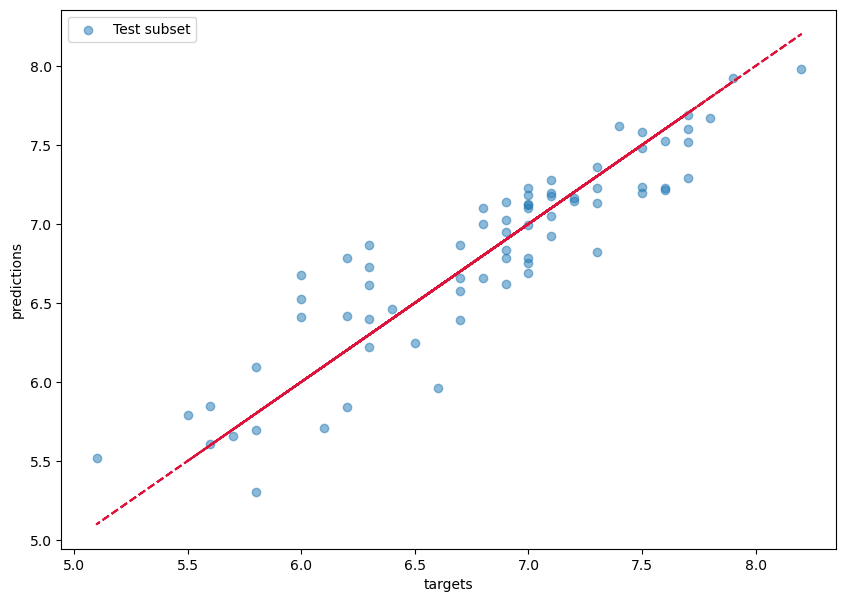

In [25]:
# Plot
predictions = lr.predict(Xdf)#X_test)
#predictions2 = lr.predict(X_train)

plt.figure(figsize=(10,7))
#plt.scatter(y_train, predictions2, alpha=0.5, color='violet', label='Train subset')
plt.scatter(ydf, predictions, alpha=0.5, label='Test subset')
plt.plot(y_train, y_train, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.legend()
plt.show()

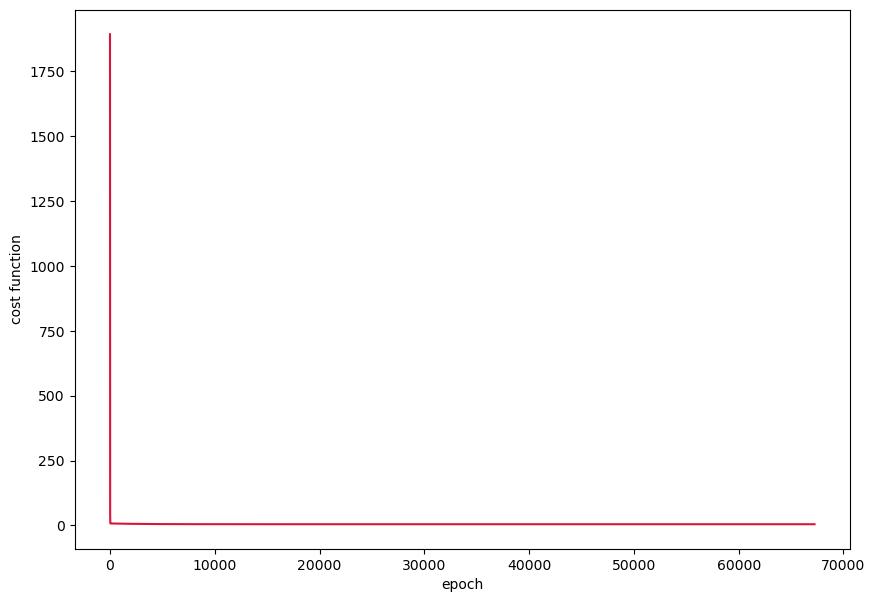

In [14]:
# Plot Training history

plt.figure(figsize=(10,7))
plt.plot(lr.history, color='crimson')
#plt.plot(lr.history[0:100], color='crimson')
plt.ylabel(r'cost function')
plt.xlabel(r'epoch')
plt.show()